In [1]:
### Library functions
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import random 
from matplotlib import animation
import networkx.algorithms.centrality as nx_centrality
from collections import deque
from matplotlib import animation
import math

/Users/fengboyang/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

## Training dataset

The global parameters of the generate_random_graph function:
1. FAKE_DIFF_ITER: the fake nodes diffusion iteration
2. FAKE_SEED_NUM: the initial fake seed set number
3. NODE_NUM: the graph nodes number
4. EDGE_NUM: the graph edges number 
5. M_INDEX: the generate graph method index

In [2]:
def generate_random_graph(difusion_iteration, method_index,fake_seed_num, num_nodes , num_edges , probability = 0.5,m = 2, radius = None, k_nearest_neighbor = None, degree = None, seed = None):
    random_graph = nx.Graph()
    if method_index == 0:
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)

    elif method_index == 1:
        random_graph = nx.erdos_renyi_graph(num_nodes, probability)

    elif method_index == 2:
         # m means the edges number from the create point to existing point
        random_graph = nx.barabasi_albert_graph(num_nodes, m)

    elif method_index == 3:
        random_graph = nx.watts_strogatz_graph(num_nodes, k_nearest_neighbor, probability)
#     elif method_index == 4:
#         random_graph=nx.gnc_graph(num_nodes)

#     elif method_index == 4:
#         random_graph = nx.random_geometric_graph(num_nodes, radius)   
        
#     elif method_index == 5:
#         random_graph = nx.random_regular_graph(degree, num_nodes)

#     elif method_index == 7:
#         #p1 = nodes in the tree connected,  p2 = nodes in the tree body connected
#         random_graph = nx.random_lobster(num_nodes, probability, probability)

#     elif method_index == 8:
#         p = probability # probability connected with its nearest neighbor
#         q = probability # probability connected with other nodes
#         random_graph = nx.newman_watts_strogatz_graph(num_nodes, p, q)

#     elif method_index == 9:
#         random_graph = nx.create_powerlaw_cluster_graph(num_nodes, k_nearest_neighbor, probability, seed=seed)

#     elif method_index == 10:
#         # A random maximal planar graph is a graph in which every possible edge that can be added without creating a cycle is included, 
#         # resulting in a planar graph with the maximum number of edges. 
#         random_graph = nx.random_maximal_planar_graph(num_nodes)

#     elif method_index == 11:
#         random_graph = nx.random_threshold_graph(num_nodes, probability)

#     elif method_index == 12:
#         random_graph = nx.create_forest_fire_graph(num_nodes, probability, probability, seed=seed)

#     elif method_index == 13:
#         k = k_nearest_neighbor # This k is different with KNN, it generates a scale-free network where new nodes are added with k initial edges
#         random_graph = nx.extended_barabasi_albert_graph(num_nodes, k, probability)


#     elif method_index == 15:
#         # lollipop graph
#         m = num_nodes // 2  # Number of nodes in the complete graph
#         n = num_nodes - m - 1  # Number of nodes in the cycle graph

#         G_complete = nx.complete_graph(m)
#         G_cycle = nx.cycle_graph(n)

#         # Connect the complete graph and cycle graph
#         G_complete.add_edge(m-1, m)
#         random_graph = nx.compose(G_complete, G_cycle)
    
    
    for (u,v) in random_graph.edges:
        if FIXED == True:
            random_graph.edges[u, v]["weight"] = PROBABILITY
        else:
            random_graph.edges[u, v]["weight"] =  random.uniform(0,1)
    for node in random_graph.nodes():
        random_graph.nodes[node]['state'] = 0 # 0初始状态；1:true；2:fake
    node_number = random_graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for _ in range(difusion_iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in random_graph.neighbors(v): 
                if random_graph.nodes[nbr]['state'] == 0 : 
                    edge_data = random_graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        random_graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()
        temp_fake.clear()    
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
        
    return random_graph,fake_active_nodes,fake_seed_set,fake_nodes_set


## Create and normalize test data

In [3]:
# !pip install scanpy

In [4]:
import scanpy as sc 
import scipy as sp
import scipy.sparse  # call as sp.sparse

# filename_ca_HepTh = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-HepTh.mtx"
# filename_ca_GrQc = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-GrQc.mtx"
# filename_tech_p2p_gnutella = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\tech-p2p-gnutella.mtx"
filename_ca_HepTh = 'ca-HepTh.mtx'
filename_ca_GrQc = 'ca-GrQc.mtx'
filename_tech_p2p_gnutella = 'tech-p2p-gnutella.mtx'

In [5]:
def read_graph(filename):
    adata = sc.read(filename)
    G = nx.from_scipy_sparse_array(adata.X, create_using=nx.MultiGraph)
    print("node number:",G.number_of_nodes())
    print("edge number:",G.number_of_edges())
    return G, G.number_of_nodes(), G.number_of_edges()

In [6]:
G_ca_HepTh,N_ca_HepTh,E_ca_HepTh= read_graph(filename_ca_HepTh)

node number: 9877
edge number: 25998


In [7]:
G_ca_GrQc,N_ca_GrQc,E_ca_GrQc = read_graph(filename_ca_GrQc)

node number: 5242
edge number: 14496


In [8]:
G_tech_p2p_gnutella,N_tech_p2p_gnutella,E_tech_p2p_gnutella = read_graph(filename_tech_p2p_gnutella)

node number: 62561
edge number: 147878


In [9]:
def normalization_graph(graph):
    graph_node_number = graph.number_of_nodes()
    graph_edge_number = graph.number_of_edges()
    for node in graph.nodes():
        graph.nodes[node]['state'] = 0
    for (u,v) in graph.edges:
        graph.edges[u,v]['weight'] = random.uniform(0,1)
    return graph,graph_node_number,graph_edge_number

In [10]:
def fake_nodes_diffusion(graph,fake_seed_num,iteration):
    node_number = graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for node in fake_seed_set:
        graph.nodes[node]['state'] = 2
    #fake news diffusion
    for _ in range(iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in graph.neighbors(v): 
                if graph.nodes[nbr]['state'] == 0 : 
                    edge_data = graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()  
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
    return graph,fake_active_nodes

In [11]:
def statistic_draw_graph(Graph,draw = False):
    color_list = []
    fake = 0
    true = 0
    normal = 0
    for node in Graph.nodes():
        if Graph.nodes[node]['state'] == 0:
            normal += 1
            color_list.append('blue')
        elif Graph.nodes[node]['state'] == 1:
            true += 1
            color_list.append('green')
        elif Graph.nodes[node]['state'] == 2:
            fake += 1
            color_list.append('red')
    print("normal nodes number:",normal)
    print("true nodes number:",true)
    print("fake nodes number:",fake)
    print("the edge of graph:",Graph.number_of_edges())
    #nx.draw(Graph, node_color= color_list) 
    if draw:
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Environment Class

The global parameters in the Environment Class:
1. ITERATION: control the diffusion times during the true and fake nodes antagonistic process
2. MAX_STEP: control the max step of this epoch
3. SEED_SIZE: the initial size of the seed set, the initial parameters of Env class.

The input variable of the Env() class:
1. graph: the training graph or testing graph
2. seed_size: SEED_SIZE;the initial size of the seed set
3. fake_set: the initial fake

The functions in the Env class:
1. reset: reset the parameters
2. step: the experiment excuation progress
3. select_initial_seeds: select the initial seed randomly
4. select_initial_seeds_rules: select the intial seed set according to different criterion
5. add_seed: add the seed nodes according to the action number from the agent
6. get_state: get the current state of the graph
7. diffusion_process: the procees of the true and fake nodes antagonistic
8. get_image: draw the image of the graph

In [90]:
class Env():
    def __init__(self, graph,seed_size,fake_set):
        self.graph_initial = graph
        self.seed_size = seed_size
        self.seed_set = []
        self.fake_set = fake_set
        self.state = None
        self.reset()

    def reset(self):
        #select the seed set:
        self.graph = self.graph_initial.copy()
        self.step_count = 0
        self.add_number = 0
        self.seed_set, action = self.select_initial_seeds_rules(self.graph,self.seed_size)
        self.true_active_nodes = self.seed_set.copy()
        self.fake_active_nodes = self.fake_set.copy()
        self.state = self.get_state()
        return self.state, action
    
    def step(self,action):
        count_state0 = 0
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 0:
                count_state0 += 1
        if action > 0 and (len(self.seed_set) + ADD_SEED_NUMBER <= self.graph.number_of_nodes()) and count_state0 >= ADD_SEED_NUMBER:
            self.add_number += 1
            centrality_methods = ["None", "random", "degree", "closeness", "betweenness", "eigenvector"]
            centrality_method = centrality_methods[action]
            self.seed_set = self.add_seed(self.graph,self.seed_set,action,ADD_SEED_NUMBER)
            if(self.true_active_nodes[-ADD_SEED_NUMBER:]!= self.seed_set[-ADD_SEED_NUMBER:]):
                self.true_active_nodes.extend(self.seed_set[-ADD_SEED_NUMBER:])
        self.graph,self.true_active_nodes,self.fake_active_nodes = self.diffusion_process(self.graph,
                                                                                     self.true_active_nodes,
                                                                               self.fake_active_nodes,ITERATION)
        #print("current image:")
        #self.get_image(self.graph)
        
        # terminal condition                                                                    
        all_true_nodes = []
        all_fake_nodes = []
        normal_nodes= []                                                                             
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 1:
                all_true_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 2:
                all_fake_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 0:
                normal_nodes.append(node)
        number_nodes = len(self.graph.nodes())
        number_true_nodes = len(all_true_nodes) 
        number_fake_nodes = len(all_fake_nodes)
        # terminal condition: over the MAX_STEP / less 1% nodes are normal nodes
        terminated = bool(self.step_count >= MAX_STEP 
                        or len(normal_nodes)<=0.01 * number_nodes) 
#         penatly = math.pow(1.2,self.add_number)
#         print("penatly:",penatly)
#         print(len(all_true_nodes)  - len(all_fake_nodes))
        penatly = math.pow(1.05,self.add_number)
        if not terminated:
            if len(all_true_nodes)>len(all_fake_nodes):
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly + 5)/(len(all_true_nodes) + len(all_fake_nodes))
                #print(">:",reward)
            else:
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly)/(len(all_true_nodes) + len(all_fake_nodes))
                
                #print("<:",reward)
            done = False
            self.step_count +=1
        else: 
            # when this iteration is end, give a little big reward.
            reward = 30
            done = True
#         if not terminated:
#             if len(all_true_nodes)>len(all_fake_nodes):
#                 reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly )/(len(all_true_nodes) + len(all_fake_nodes))#+0.7
#                 print(">:",reward)
#             else:
#                 reward = (len(all_true_nodes)  - len(all_fake_nodes))/(len(all_true_nodes) + len(all_fake_nodes)) #-0.5
#                 print("<:",reward)
#             done = False
#             self.step_count +=1
#         else:
#             reward = 10 +  (MAX_STEP - self.step_count) * 0.25
#             done = True
            
#             self.step_count >= MAX_STEP: 
#             # when this iteration is end, give a little big reward.
#             reward = 20
#             done = True
#         elif len(normal_nodes)<=0.01 * number_nodes:
#             reward = 30
#             done = True
        self.state = self.get_state()
        return self.state, reward ,done 
    # select the initial seed set randomly
    def select_initial_seeds(self, graph, seed_number):
        node_number = graph.number_of_nodes()
        start_node_index = [0] *seed_number
        index_range = range(0,  node_number)
        start_node_index = random.sample(index_range, seed_number)
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index
    # select the initial seed set according to different rules
    def select_initial_seeds_rules(self,graph,seed_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        action = random.randint(0,5)
        start_node_index = []
        centrality_scores = []
        if action == 0:   
            node_number = graph.number_of_nodes()
            start_node_index = [0] *seed_number
            index_range = range(0,  node_number)
            start_node_index = random.sample(index_range, seed_number)
        else:
            if action == 1:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 2:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 3:
                centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
            elif action == 4:
                centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
            elif action == 5:
                centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
            for _ in range(seed_number):
                max_number = max(centrality_scores)
                index = centrality_scores.index(max_number)
                while(graph.nodes[index]['state'] != 0):
                    centrality_scores[index] = -1
                    max_number = max(centrality_scores)
                    index = centrality_scores.index(max_number)  
                start_node_index.append(index)
                centrality_scores[index] = -1
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index,action
        
    def add_seed(self,graph,seed_set,action,add_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        new_seed_set = []
        new_seed_set = seed_set.copy()
        centrality_scores = []
        state0 = 0
        for node in graph.nodes():
            if graph.nodes[node]['state'] == 0:
                state0 += 1
        if state0 >= ADD_SEED_NUMBER:
            if action == 1:
                node_number = graph.number_of_nodes()
                for _ in range(ADD_SEED_NUMBER):
                    index = random.randint(0,node_number-1)
                    while (index in seed_set) or (graph.nodes[index]['state'] in [1,2])  :
                        index = random.randint(0,node_number-1)
                    new_seed_set.append(index)
                    graph.nodes[index]['state']  = 1

            else: 
                if action == 2:
                    centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
                elif action == 3:
                    centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
                elif action == 4:
                    centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
                elif action == 5:
                    centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
                for node in seed_set:
                    centrality_scores[node] = -1
                for _ in range(ADD_SEED_NUMBER):
                    index = centrality_scores.index(max(centrality_scores))
                    while(graph.nodes[index]['state'] != 0):
                        index = centrality_scores.index(max(centrality_scores))
                        # print(index)
                        centrality_scores[index] = -1
                    # print("add_seed, index:",index)
                    new_seed_set.append(index)
                    graph.nodes[index]['state'] = 1
                    centrality_scores[index] = -1
        return new_seed_set
    def get_state(self):
        node_state = []
        for node in self.graph.nodes():
            node_state.append(self.graph.nodes[node]['state'])
        return nx.to_numpy_array(self.graph), len(self.seed_set), node_state
    
    def diffusion_process(self, G ,true_active_set,fake_active_set,itertaion):
        G = self.graph.copy()
        true_active_nodes = true_active_set.copy()
        fake_active_nodes = fake_active_set.copy()
        # print("true_active_nodes begin:",true_active_nodes)
        # print("fake_active_nodes begin:",fake_active_nodes)
        for _ in range(itertaion):
            tmp_true_nodes ={}
            for v in true_active_nodes: 
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            G.nodes[nbr]['state'] == 3
                            tmp_true_nodes.update({nbr:random_possibility})
                            true_active_set.append(nbr)
                    else:
                        continue
            tmp_fake_nodes ={}
            for v in fake_active_nodes:
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0,3]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            tmp_fake_nodes.update({nbr:random_possibility})
                            fake_active_set.append(nbr)
                            G.nodes[nbr]['state'] == 4
            true_active_nodes = list(tmp_true_nodes.keys())
            fake_active_nodes = list(tmp_fake_nodes.keys())
            for node in tmp_true_nodes.keys():
                if node in tmp_fake_nodes.keys() :
                    if tmp_true_nodes.get(node) >= tmp_fake_nodes.get(node):
                        fake_active_set.remove(node)
                        fake_active_nodes.remove(node)
                    elif tmp_true_nodes.get(node) < tmp_fake_nodes.get(node):
                        true_active_set.remove(node)
                        true_active_nodes.remove(node)
                else:
                    continue
            for node in true_active_set:
                G.nodes[node]['state'] = 1
            for node in fake_active_set:
                G.nodes[node]['state'] = 2
            # print("true_active_nodes",true_active_set)
            # print("fake_active_nodes",fake_active_set)
        return G,true_active_nodes,fake_active_nodes

        
    def get_image(self,Graph):
        color_list = []
        for node in Graph.nodes():
            if Graph.nodes[node]['state'] == 0:
                color_list.append('blue')
            elif Graph.nodes[node]['state'] == 1:
                color_list.append('green')
            elif Graph.nodes[node]['state'] == 2:
                color_list.append('red')
        #nx.draw(Graph, node_color= color_list) 
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Agent

##  Device: GPU/CPU
Note:

if you use Macbook with Apple M1/M2 core, please run the code in the Mac Device;

if you use Windows with CUDA core, please run the code in the Windows Device;

### Mac Device

In [13]:
# # if use MAC(Apple M1/M2) please run the follow codes
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Windows Device

In [15]:
import torch
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: False


In [16]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name()
    print("GPU Device Name:", device_name)

In [17]:
if torch.backends.cudnn.is_available():
    print("cuDNN Available")

In [18]:
# if use CUDA please run the follow codes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## DQN Agent

The input variable of the DQNAgent() class link to the global parameters:
1. state_dim: STATE_DIM; Dimension of state
2. action_dim: ACT_DIM; Dimension of action space 
3. learning_rate: LR;
4. gamma: GAMMA
5. epsilon: EPSILON
6. epsilon_decay: EPSILON_DECAY

In [14]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay):
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=10000)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = self.q_network(state)
#           q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
            return torch.argmax(q_values.cpu()).item()

    def remember(self, state, action, reward, next_state, done):
        #state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            #print("next_state:", next_state)
            #state = torch.tensor(state, dtype=torch.float32).to(device)
            state_tensor = state_to_tensor(state).to(device)
            #print(state_tensor.shape)
            #print(self.q_network(state_tensor).shape)
            action_index = torch.tensor(action, dtype=torch.long)
            target = self.q_network(state_tensor)[0, action_index]
            #target = self.q_network(state_tensor)[action]
            if done:
                target_value = reward
            else:
                next_state_tensor = state_to_tensor(next_state).to(device)
                #next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
                next_q_values = self.target_network(next_state_tensor).detach()
                target_value = reward + self.gamma * torch.max(next_q_values).item()

            #loss = self.loss_fn(target, torch.tensor(float(target_value)))
            loss = self.loss_fn(target, torch.tensor(float(target_value)).to(device))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, path):
        torch.save(self.q_network.state_dict(), path)

    def load(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.q_network.state_dict())

### Transform array state to tensor state

In [15]:
def state_to_tensor(state):
    graph, num_seed_nodes, node_state = state
    
    graph_tensor = torch.tensor(graph, dtype=torch.float32).view(-1).unsqueeze(0)
    num_seed_nodes_tensor = torch.tensor([num_seed_nodes], dtype=torch.float32).unsqueeze(0)
    node_state_tensor = torch.tensor(node_state, dtype=torch.float32).unsqueeze(0)
    
#     state_tensor = torch.cat((graph_tensor, num_seed_nodes_tensor, node_state_tensor), dim=1)
    state_tensor = torch.cat((num_seed_nodes_tensor, node_state_tensor), dim=1)
    
    return state_tensor

## Neural Network

In [16]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)# (2500 + 50 + 2) (10000 + 100 + 2)
        
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Function
The input valiable of train_dqn function:

1. agent: the initialized Agent class
2. env: the initialized Env class
3. batch_size: BATCH_SIZE
4. update_target_every: UPDATE;How many iterations to update the network
5. dqn_agent_name: the name of DQN agent, the file extension is '.pth'
6. brenchmark_action: Start benchmark comparison and specifying an action(1-5)
7. Demo: Whether state should be displayed or saved each time

In [17]:
def train_dqn(agent, env, episodes, batch_size, update_target_every,dqn_agent_name  = None,brenchmark_action = None,Demo = False):
    state_history= []
    rewards_list = []
    for episode in range(episodes):
        state,init_action = env.reset()
        if brenchmark_action is not None:
            init_action = brenchmark_action
        #print(state)
#         state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            #print(state_tensor)
            if brenchmark_action is not None:
                action = brenchmark_action
            else:
                action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            #print(next_state)
            agent.remember(state, action, reward, next_state, done)
            agent.train(batch_size)
            total_reward += reward
            state = next_state
            if Demo:
                state_history.append(state)  # Add current state to state_history
        if not Demo:
            state_history.append(state)
        rewards_list.append(total_reward)
        if episode % update_target_every == 0:
            agent.update_target_network()

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
    if dqn_agent_name is not None:
        agent.save(dqn_agent_name)
    return state_history, rewards_list

# Testing Function

In [18]:
def test_dqn(agent, env, episodes):
    for episode in range(episodes):
        state,init_action = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# Display functions

## Display the training or testing process

In [19]:
import matplotlib.pyplot as plt
from matplotlib import animation

In [20]:
def state2graph(state):
    graph = nx.from_numpy_array(state[0])
    #print(graph.nodes())
    for node in graph.nodes():
        graph.nodes[node]['state'] = state[2][node]
    return graph

In [21]:
def create_color_list(graph):
    color_list = []
    #create color list
    #print(graph)
    for node in graph.nodes():
        if graph.nodes[node]['state'] == 0:
            color_list.append('blue')
        elif graph.nodes[node]['state'] == 1:
            color_list.append('green')
        elif graph.nodes[node]['state'] == 2:
            color_list.append('red')
    return color_list

In [22]:
def define_pos(state):
    graph = nx.from_numpy_array(state[0])
    position = spring_layout(graph)
    position = nx.circular_layout(graph)   
    return position

In [23]:
def display(state):
    fig, ax = plt.subplots()
    graph = state2graph(state[0])
    pos = define_pos(state[0])
    color_list = create_color_list(graph)
    nx.draw(graph, pos, node_color= color_list)
    
    def animate(frame):
        ax.clear()
        #print("frame,",frame)
        #print(state[frame])
        graph = state2graph(state[frame])
        color_list = create_color_list(graph)
        nx.draw(graph, pos, node_color= color_list)
    anim = animation.FuncAnimation(fig, animate, frames=len(state), interval=200)
    anim.save('train.gif', writer='PillowWriter')
    anim.save("train.mp4",writer='ffmpeg')
    
    plt.show()

## Show the change of reward

In [36]:
def reward_image(rewards_list):
    x = range(1,ALL_EPISODES+1)
    print(x)
    plt.plot(x,rewards_list,'s-')
    plt.xlabel("Iteration")
    plt.ylabel("Total reward")
    plt.show()

# Global parameters

In [56]:
# the Global parameter of generate_random_graph
FAKE_DIFF_ITER = 1 # the fake nodes diffusion iteration
FAKE_SEED_NUM = 3 # the initial fake seed set number
NODE_NUM = 100 # the intial graph nodes number
EDGE_NUM = 200 # the intial graph edges number
M_INDEX = 0 # the generate graph method index

# the Global parameter of Env class
ITERATION = 1 #control the diffusion times during the true and fake nodes antagonistic process
MAX_STEP = 40 # control the max step of this epoch
SEED_SIZE = 10 # the initial size of the seed set, the initial parameters of Env class.
ADD_SEED_NUMBER = 1 # the number of nodes that are added to seed set

# the Global parameter of Agentclass
state_dim = NODE_NUM + 1 #state_dim: Dimension of state
action_dim = 6 #action_dim:  Dimension of action space
LR = 0.001#learning_rate: 
GAMMA = 0.99 # gamma:
EPSILON = 1.0# epsilon: 
EPSILON_DECAY = 0.995 # epsilon_decay: 
# the Global parameter of train and test function
batch_size = 128 #batch_size: 
UPDATE = 10 #update_target_every: 
ALL_EPISODES = 200 # total number of iteration times

FIXED = False

# Experiment

# 3.Change the type of initial graph
graph index: 1 2 14 15 ；传播次数1；

In [198]:
# the Global parameter of generate_random_graph
FAKE_DIFF_ITER = 1 # the fake nodes diffusion iteration
FAKE_SEED_NUM = 5 # the initial fake seed set number
NODE_NUM = 500 # the intial graph nodes number
EDGE_NUM = 1500 # the intial graph edges number
M_INDEX = 0 # the generate graph method index

# the Global parameter of Env class
ITERATION = 1 #control the diffusion times during the true and fake nodes antagonistic process
MAX_STEP = 40 # control the max step of this epoch
SEED_SIZE = 10 # the initial size of the seed set, the initial parameters of Env class.
ADD_SEED_NUMBER = 1 # the number of nodes that are added to seed set

# the Global parameter of Agentclass
state_dim = NODE_NUM + 1 #state_dim: Dimension of state
action_dim = 6 #action_dim:  Dimension of action space
LR = 0.001#learning_rate: 
GAMMA = 0.99 # gamma:
EPSILON = 1.0# epsilon: 
EPSILON_DECAY = 0.995 # epsilon_decay: 
# the Global parameter of train and test function
batch_size = 128 #batch_size: 
UPDATE = 10 #update_target_every: 
ALL_EPISODES = 200 # total number of iteration times

FIXED = False

### graph index: 1

In [199]:
M_INDEX = 1

In [200]:
intial_train_graph_Method1,active_fake_set_Method1,intial_fake_set_Method1,all_fake_nodes_Method1 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM,probability =0.015 )

In [201]:
statistic_draw_graph(intial_train_graph_Method1)

normal nodes number: 480
true nodes number: 0
fake nodes number: 20
the edge of graph: 1879


In [202]:
intial_train_graph_Method1.number_of_edges()

1879

In [253]:
len(active_fake_set_Method1)

15

In [203]:
SEED_SIZE =int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_Method1)) 
print(SEED_SIZE) 

7


In [204]:
for (u,v) in intial_train_graph_Method1.edges:
    print(intial_train_graph_Method1.edges[u,v]['weight']) 

0.19415528691491313
0.6631642265982491
0.3764342234687096
0.16668990501383962
0.31291691389938303
0.3803979237078309
0.2906168399641378
0.12644133210087882
0.8615627678670047
0.8565464699200435
0.01477427976967638
0.2189642295235643
0.4227124716318381
0.2850853604055994
0.20183434815277101
0.9374474048219269
0.24448665352801957
0.47913993495510177
0.6384386830646014
0.07320235666454011
0.4057510289738704
0.3775761490278009
0.852763810678539
0.06156221443297305
0.057222412896506314
0.06639825591587034
0.07233794051643483
0.47540715480624285
0.6136681410520411
0.21280323233329068
0.7582720862946515
0.376530842018699
0.9935129601838988
0.10984649751473119
0.1323273620496258
0.21938458180592657
0.5450600612274618
0.12997532280276825
0.753979107039379
0.0058556461369473345
0.04735433799303179
0.35213165812182945
0.6658378052151651
0.8094640808930406
0.24328789530766703
0.26677064202199063
0.43889964785711166
0.7298098174264918
0.11471686754324317
0.033673929856597784
0.5916369269979965
0.50

In [205]:
env_Method1 = Env(intial_train_graph_Method1, SEED_SIZE,active_fake_set_Method1)
agent_Method1 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)
state_history_Method1, rewards_list_Method1 = train_dqn(agent_Method1,env_Method1, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Method1.pth")

Episode 1/200, Total Reward: 23.17446089755673
Episode 2/200, Total Reward: 28.691818328535554
Episode 3/200, Total Reward: 29.971104517415647
Episode 4/200, Total Reward: 31.17025607837622
Episode 5/200, Total Reward: 30.484283602395617
Episode 6/200, Total Reward: 27.346394597938634
Episode 7/200, Total Reward: 30.423635670090725


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1713/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 8/200, Total Reward: 25.20097624104948
Episode 9/200, Total Reward: 28.593646893485744
Episode 10/200, Total Reward: 29.073370697415587
Episode 11/200, Total Reward: 28.844246545493725
Episode 12/200, Total Reward: 28.790303654723495
Episode 13/200, Total Reward: 30.037791419690485
Episode 14/200, Total Reward: 29.559944764490446
Episode 15/200, Total Reward: 27.503922153164826
Episode 16/200, Total Reward: 24.498273659544022
Episode 17/200, Total Reward: 30.1765031631993
Episode 18/200, Total Reward: 29.613424557943745
Episode 19/200, Total Reward: 29.72957526016737
Episode 20/200, Total Reward: 28.7493743109683
Episode 21/200, Total Reward: 27.885118772220064
Episode 22/200, Total Reward: 26.826156231429707
Episode 23/200, Total Reward: 22.911203003204385
Episode 24/200, Total Reward: 27.26717345327609
Episode 25/200, Total Reward: 25.25708310528485
Episode 26/200, Total Reward: 29.916444845274103
Episode 27/200, Total Reward: 29.260548776694666
Episode 28/200, Total Reward: 

Episode 176/200, Total Reward: 29.51062746183219
Episode 177/200, Total Reward: 29.928621006309484
Episode 178/200, Total Reward: 28.506192191888296
Episode 179/200, Total Reward: 29.335126625195468
Episode 180/200, Total Reward: 32.31788136570175
Episode 181/200, Total Reward: 29.912803336521755
Episode 182/200, Total Reward: 30.72842080305585
Episode 183/200, Total Reward: 29.545850385359138
Episode 184/200, Total Reward: 30.03236864561775
Episode 185/200, Total Reward: 22.99269727194836
Episode 186/200, Total Reward: 26.552224124235536
Episode 187/200, Total Reward: 30.810143862714394
Episode 188/200, Total Reward: 27.551212870188138
Episode 189/200, Total Reward: 29.703097565011156
Episode 190/200, Total Reward: 29.437886833080597
Episode 191/200, Total Reward: 28.862130426840018
Episode 192/200, Total Reward: 25.207377812720694
Episode 193/200, Total Reward: 28.697016101128742
Episode 194/200, Total Reward: 29.900183024363155
Episode 195/200, Total Reward: 29.0571767981694
Episode

### graph index: 2

In [206]:
M_INDEX = 2

In [207]:
intial_train_graph_Method2,active_fake_set_Method2,intial_fake_set_Method2,all_fake_nodes_Method2 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM, m =3 )

In [254]:
len(active_fake_set_Method2)

13

In [208]:
SEED_SIZE =int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_Method2)) 
print(SEED_SIZE) 

6


In [209]:
statistic_draw_graph(intial_train_graph_Method2)

normal nodes number: 482
true nodes number: 0
fake nodes number: 18
the edge of graph: 1491


In [210]:
intial_train_graph_Method2.number_of_edges()

1491

In [211]:
for (u,v) in intial_train_graph_Method2.edges:
    print(intial_train_graph_Method2.edges[u,v]['weight']) 

0.11902694319816876
0.5956491918019821
0.7337501312703173
0.6452941426526548
0.033055222205311874
0.42206386552319375
0.5661949429742709
0.3845642603361853
0.426313177096893
0.405432986759944
0.027760792677270274
0.3229103918096571
0.45063371992752577
0.10514493969136363
0.96258793571789
0.9897695985057205
0.4165998417659569
0.9654243709216435
0.7383796976569085
0.9515242672679475
0.6654332271584418
0.6474549739232203
0.07942668603736358
0.2769196650045914
0.6089337336149943
0.9141485870566829
0.7250518972219564
0.3737842848026822
0.520891685169959
0.36250766404819446
0.5157175742634466
0.029115861091879913
0.8207243155730282
0.9736303022499339
0.17402269447101204
0.40261702481282147
0.7218579510606586
0.4212010520890971
0.07186056877966918
0.1945588616770051
0.6210321271071169
0.5869615969765134
0.11383678160971833
0.7249164255104914
0.3800521118388469
0.6773403429423923
0.7319154462223291
0.44648532247390327
0.7955020650251274
0.39554667713024994
0.7678417685823952
0.1621655167163473

In [212]:
env_Method2 = Env(intial_train_graph_Method2, SEED_SIZE,active_fake_set_Method2)
agent_Method2 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)
state_history_Method2, rewards_list_Method2 = train_dqn(agent_Method2,env_Method2, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Method2.pth")

Episode 1/200, Total Reward: 32.915427101477896
Episode 2/200, Total Reward: 13.550099182699931
Episode 3/200, Total Reward: 34.022766918717366


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1713/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 4/200, Total Reward: 24.90516977904862
Episode 5/200, Total Reward: 31.02903966407127
Episode 6/200, Total Reward: 34.43257277893394
Episode 7/200, Total Reward: 33.55918915692526
Episode 8/200, Total Reward: 35.32946611998414
Episode 9/200, Total Reward: 41.620111265490095
Episode 10/200, Total Reward: 16.664817945065593
Episode 11/200, Total Reward: 37.23839289729407
Episode 12/200, Total Reward: 34.02404771672179
Episode 13/200, Total Reward: 12.643649879922691
Episode 14/200, Total Reward: 35.90174853688852
Episode 15/200, Total Reward: 37.92000414431201
Episode 16/200, Total Reward: 38.234899603513504
Episode 17/200, Total Reward: 20.370399202394296
Episode 18/200, Total Reward: 38.25211581103786
Episode 19/200, Total Reward: 37.33875234242434
Episode 20/200, Total Reward: 36.766835633672464
Episode 21/200, Total Reward: 35.23191524928501
Episode 22/200, Total Reward: 36.03816047226616
Episode 23/200, Total Reward: 34.392186887300525
Episode 24/200, Total Reward: 34.575077

Episode 173/200, Total Reward: 40.813192176778635
Episode 174/200, Total Reward: 31.645360964677653
Episode 175/200, Total Reward: 36.87176964615047
Episode 176/200, Total Reward: 34.584635433193185
Episode 177/200, Total Reward: 4.8047106199546725
Episode 178/200, Total Reward: 38.649975778528166
Episode 179/200, Total Reward: 36.7651079649151
Episode 180/200, Total Reward: 33.45128332713158
Episode 181/200, Total Reward: 40.192950553020744
Episode 182/200, Total Reward: 42.9532327288912
Episode 183/200, Total Reward: 32.89343806206407
Episode 184/200, Total Reward: 35.390391588096016
Episode 185/200, Total Reward: 39.01686859902501
Episode 186/200, Total Reward: 35.863802447195994
Episode 187/200, Total Reward: 6.447876709113828
Episode 188/200, Total Reward: 31.212300359730833
Episode 189/200, Total Reward: 39.24889432556655
Episode 190/200, Total Reward: 40.42066632969949
Episode 191/200, Total Reward: 45.71932249178467
Episode 192/200, Total Reward: 38.79375935764203
Episode 193/2

### graph index: 3

In [255]:
M_INDEX = 3
intial_train_graph_Method3,active_fake_set_Method3,intial_fake_set_Method3,all_fake_nodes_Method3 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM,probability=1,k_nearest_neighbor =2)
SEED_SIZE = len(active_fake_set_Method3)

In [206]:
SEED_SIZE

4

normal nodes number: 488
true nodes number: 0
fake nodes number: 12
the edge of graph: 500


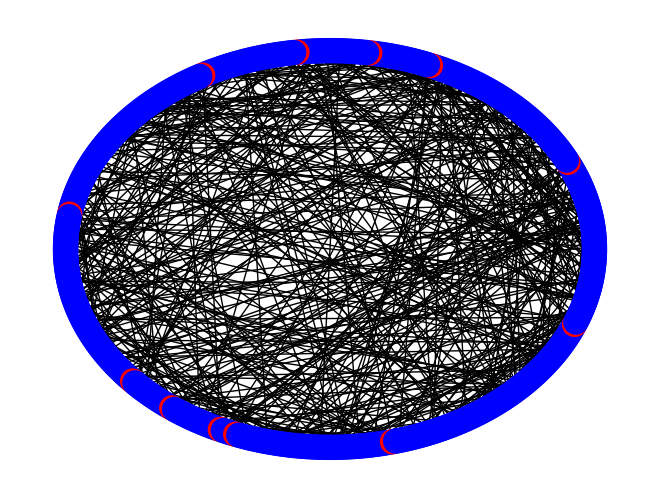

In [256]:
statistic_draw_graph(intial_train_graph_Method3,draw=True)

In [208]:
intial_train_graph_Method3.number_of_edges()

500

In [209]:
for (u,v) in intial_train_graph_Method3.edges:
    print(intial_train_graph_Method3.edges[u,v]['weight']) 

0.6910058430445124
0.7736831473104506
0.7337592363622039
0.37187915103358793
0.47519134926680684
0.6158036281930481
0.10427973933993373
0.9724947871137686
0.6579902778050691
0.6300682856793315
0.5156778368280653
0.3816745866201643
0.1288643977264411
0.8230493577404049
0.1144382573689402
0.17652506102912147
0.7904723300089646
0.11653591948396358
0.9933442102612183
0.19624495334590186
0.5258619506597524
0.7766932380369279
0.8609460741563096
0.3902076865746409
0.7546918454074413
0.6574700236869279
0.17797432806679991
0.0835898027279457
0.7436341715399208
0.6370167403216405
0.7691006484454499
0.9590970018714323
0.1816747494488984
0.9102906034354605
0.6566737492185805
0.14235210014169253
0.5750546296838822
0.6025622162046089
0.28206755233211644
0.7622737344469269
0.8644523029337634
0.5636365566947198
0.29610424131449864
0.8527201098753735
0.7789315699781215
0.8229343775504291
0.7459026667280879
0.24275524720076458
0.4978928246372578
0.5375728551304964
0.5323686023551708
0.47010886053809076


In [204]:
env_Method3 = Env(intial_train_graph_Method3, SEED_SIZE,active_fake_set_Method3)
agent_Method3 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)
state_history_Method3, rewards_list_Method14 = train_dqn(agent_Method3,env_Method3, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Method3.pth")

0.8718064489188281
0.9100996112036492
0.9400036298528314
0.9762152711006842
0.9691841146702258
0.9396975742629864
0.9274232069370958
0.94004895700298
0.9472976370035193
0.949252615844544
0.9555555555555555
0.9584070796460176
0.9584070796460176
0.9595143487858719
0.960511013215859
0.9613767032967033
0.9613767032967033
0.9613767032967033
0.9637017067833697
0.9642227423580785
0.9645246605664488
0.9661609176572667
0.9661609176572667
0.9661609176572667
0.9658879213160172
0.9652446297572355
0.964159302355862
0.9625460205413849
0.9603018872577098
0.9573036731359986
0.9549956896064256
0.9500246257670135
0.9437662185405428
0.9437662185405428
0.9437662185405428
0.9437662185405428
0.9359675142354127
0.9263255815284095
0.9144776372901376
0.8999892212434322
10
Episode 1/200, Total Reward: 47.9707746944137
0.9107041840482147
0.9215281826322207
0.8831080084937413
0.8680948482043542
0.8759219748063627
0.8727655456055952
0.8788559155206839
0.8860525875762896
0.887625125125125
0.8891385767790262
0.88913

KeyboardInterrupt: 